In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import pickle

In [2]:
# FEATURE ENGINEERING 
class FeatureEngineer:
    def __init__(self, variance_ratio=0.95): 
        self.variance_ratio = variance_ratio # Tỷ lệ variance muốn giữ lại trong PCA
        self.mean = None # Trung bình dữ liệu huấn luyện (PCA)
        self.eigenvectors = None # Các eigenvectors (PCA)
        self.n_components = None # Số thành phần chính được chọn

    def process(self, X_raw, method='raw', is_training=False):
        """
        X_raw: shape (num_samples, 28, 28) - dữ liệu ảnh gốc
        method: 'raw', 'edges', 'pca'
        Returns: (num_features, num_samples) - đã chuẩn hóa và transpose
        """
        n_samples = X_raw.shape[0]
        # Flatten về (N, 784) và convert sang float32 để OpenCV xử lý
        X_flat = X_raw.reshape(n_samples, -1).astype(np.float32)

        if method == 'raw':
            return (X_flat / 255.0).T

        elif method == 'edges':
            processed = []
            for i in range(n_samples):
                img = X_raw[i].astype(np.uint8)
                gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3)
                gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3)
                mag = np.sqrt(gx*gx + gy*gy)
                mag = np.clip(mag, 0, 255)
                processed.append(mag.flatten())
            return np.array(processed).astype(np.float32).T / 255.0

        elif method == 'pca':
            X_norm = X_flat / 255.0

            if is_training:
                # PCA full (784 components)
                mean, eigenvectors = cv2.PCACompute(X_norm, mean=None)

                # Tính eigenvalues (variance từng component)
                # eigenvalue = variance theo eigenvector
                eigenvalues = np.var(np.dot(X_norm - mean, eigenvectors.T), axis=0)

                total_variance = np.sum(eigenvalues)
                running_variance = 0
                num_components = 0

                for v in eigenvalues:
                    running_variance += v # Cộng dồn variance từng component
                    num_components += 1 # Đếm số component
                    if running_variance / total_variance >= self.variance_ratio:
                        break

                self.n_components = num_components
                self.mean = mean
                self.eigenvectors = eigenvectors[:num_components]
            X_pca = cv2.PCAProject(X_norm, self.mean, self.eigenvectors)

            return X_pca.T

        else:
            raise ValueError("Method sai! Chọn 'raw', 'edges', hoặc 'pca'.")

In [3]:
# SOFTMAX REGRESSION MODEL
class SoftmaxRegression:
    def __init__(self, num_classes=10, lr=0.1, epochs=1000, batch_size=256, reg=1e-4, patience=5):
        self.num_classes = num_classes # Số lớp (digits 0-9)
        self.lr = lr # Learning rate
        self.epochs = epochs # Số epoch
        self.batch_size = batch_size # Kích thước batch
        self.reg = reg # Hệ số regularization
        self.W = None # Trọng số
        self.b = None # Bias
        self.loss_history = [] # Lịch sử loss trong quá trình huấn luyện
        self.val_acc_history = [] # Lịch sử accuracy trên tập validation

        # EARLY STOPPING
        self.patience_limit = patience      #  Giới hạn kiên nhẫn (ví dụ 5 lần)
        self.patience_counter = 0           #  Đếm số lần thất bại liên tiếp
        self.best_val_loss = float('inf')   #  Kỷ lục loss thấp nhất (khởi tạo là vô cùng)
        self.best_W = None                  #  Lưu lại W tốt nhất
        self.best_b = None                  #  Lưu lại b tốt nhất
    # Implement Softmax(z)
    def _softmax(self, z):
        z_safe = z - np.max(z, axis=0, keepdims=True) # Để tránh overflow
        exp_z = np.exp(z_safe)
        return exp_z / np.sum(exp_z, axis=0, keepdims=True)

    # Implement Cross Entropy Loss
    def _one_hot(self, y, num_samples):
        one_hot = np.zeros((self.num_classes, num_samples)) # Ma trận one-hot
        one_hot[y, np.arange(num_samples)] = 1
        return one_hot

    def _cross_entropy_loss(self, y_onehot, A, m):
        loss = -np.sum(y_onehot * np.log(A + 1e-8)) / m # Cross-entropy loss
        # Thêm L2 regularization
        l2_cost = (self.reg / (2 * m)) * np.sum(np.square(self.W))
        return loss + l2_cost

    # Gradient descent update
    def fit(self, X_train, y_train, X_val=None, y_val=None):
        """
        X_train: (num_features, num_samples)
        y_train: (num_samples,)
        """
        num_features, m = X_train.shape # Số đặc trưng và số mẫu
        self.W = np.random.randn(self.num_classes, num_features) * 0.01 # Khởi tạo trọng số với giá trị nhỏ ngẫu nhiên
        self.b = np.zeros((self.num_classes, 1)) # Khởi tạo bias bằng 0
        
        y_train_onehot = self._one_hot(y_train, m) # Chuyển y_train sang dạng one-hot

        for epoch in range(self.epochs):
            perm = np.random.permutation(m) # Tạo permutation để shuffle dữ liệu
            X_shuffled = X_train[:, perm] # Dữ liệu đã được shuffle
            y_onehot_shuffled = y_train_onehot[:, perm] # One-hot labels đã được shuffle

            # Mini-batch Gradient Descent
            for i in range(0, m, self.batch_size):
                X_batch = X_shuffled[:, i : i + self.batch_size] # Lấy batch dữ liệu
                y_batch = y_onehot_shuffled[:, i : i + self.batch_size] # Lấy batch nhãn one-hot
                m_batch = X_batch.shape[1]

                # Forward
                Z = np.dot(self.W, X_batch) + self.b # Tính Z = WX + b
                A = self._softmax(Z)

                # Backward
                dZ = A - y_batch 
                dW = (1/m_batch) * np.dot(dZ, X_batch.T) + (self.reg/m_batch)*self.W
                db = (1/m_batch) * np.sum(dZ, axis=1, keepdims=True)

                # Update
                self.W -= self.lr * dW
                self.b -= self.lr * db

            # Evaluation per epoch
            if (epoch + 1) % 10 == 0 or epoch == 0:
                # Calculate Training Loss
                Z_full = np.dot(self.W, X_train) + self.b
                A_full = self._softmax(Z_full)
                loss = self._cross_entropy_loss(y_train_onehot, A_full, m)
                self.loss_history.append(loss)

                if X_val is not None and y_val is not None:
                    # Tính Val Acc
                    y_val_pred = self.predict(X_val)
                    val_acc = np.mean(y_val_pred == y_val)
                    
                    # Tính Val Loss
                    Z_val = np.dot(self.W, X_val) + self.b
                    A_val = self._softmax(Z_val)
                    val_loss = self._cross_entropy_loss(self._one_hot(y_val, X_val.shape[1]), A_val, X_val.shape[1])
                    
                    val_msg = f" | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}"
                
                print(f"[Epoch {epoch+1}/{self.epochs}] Loss: {loss:.4f}{val_msg}")

                # EARLY STOPPING
                if X_val is not None:
                    if val_loss < self.best_val_loss:
                        self.best_val_loss = val_loss
                        self.patience_counter = 0 # Reset bộ đếm
                        # Lưu lại bộ trọng số tốt nhất
                        self.best_W = self.W.copy() 
                        self.best_b = self.b.copy()
                    else:
                        self.patience_counter += 1
                        print(f"Val Loss không giảm {self.patience_counter} lần.")
                        
                        if self.patience_counter >= self.patience_limit:
                            print("Early Stopping")
                            self.W = self.best_W 
                            self.b = self.best_b
                            break 

    def predict(self, X):
        Z = np.dot(self.W, X) + self.b
        A = self._softmax(Z)
        return np.argmax(A, axis=0)
    
    def predict_proba(self, X):
        Z = np.dot(self.W, X) + self.b
        A = self._softmax(Z)
        return A
    
    def save_model(self, filename="softmax_model.pkl", feature_engineer=None):
        data = {
            'W': self.W,
            'b': self.b
        }

        # Nếu có PCA thì lưu thêm
        if feature_engineer is not None and feature_engineer.mean is not None:
            data['pca'] = {
                'mean': feature_engineer.mean,
                'eigenvectors': feature_engineer.eigenvectors,
                'n_components': feature_engineer.n_components,
                'variance_ratio': feature_engineer.variance_ratio
            }

        with open(filename, 'wb') as f:
            pickle.dump(data, f)

        print(f"Model saved to {filename}")

    def load_model(self, filename="softmax_model.pkl", feature_engineer=None):
        with open(filename, 'rb') as f:
            data = pickle.load(f)

        self.W = data['W']
        self.b = data['b']

        # Nếu có PCA 
        if 'pca' in data and feature_engineer is not None:
            pca = data['pca']
            feature_engineer.mean = pca['mean']
            feature_engineer.eigenvectors = pca['eigenvectors']
            feature_engineer.n_components = pca['n_components']
            feature_engineer.variance_ratio = pca['variance_ratio']

            print("Model + PCA loaded")
        else:
            print("Model loaded (no PCA)")


In [4]:
# EVALUATION METRICS
def evaluate_metrics(y_true, y_pred, class_names=None):
    if class_names is None:
        class_names = [str(i) for i in range(10)]
    
    # 1. Confusion Matrix
    num_classes = len(class_names)
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    
    # 2. Precision, Recall, F1
    print("\n--- Detailed Classification Report ---")
    print(f"{'Class':<6} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
    
    precisions, recalls, f1s = [], [], []
    
    for i in range(num_classes):
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp
        fn = np.sum(cm[i, :]) - tp
        
        p = tp / (tp + fp) if (tp + fp) > 0 else 0
        r = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2*p*r / (p+r) if (p+r) > 0 else 0
        
        precisions.append(p)
        recalls.append(r)
        f1s.append(f1)
        print(f"{class_names[i]:<6} {p:.4f}     {r:.4f}     {f1:.4f}")
        
    print("-" * 40)
    print(f"MACRO AVG: P={np.mean(precisions):.4f}, R={np.mean(recalls):.4f}, F1={np.mean(f1s):.4f}")
    print(f"ACCURACY:  {np.mean(y_true == y_pred):.4f}")
    
    return cm

def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [5]:
# LOAD DATA AND SPLIT
data = np.load("mnist.npz")

X_train_full_img = data["x_train"].reshape(-1, 28, 28)
y_train_full = data["y_train"].astype(int)

X_test_img = data["x_test"].reshape(-1, 28, 28)
y_test = data["y_test"].astype(int)

# Chia theo tỉ lệ
val_ratio = 0.2
val_size = int(len(X_train_full_img) * val_ratio)

X_val_img = X_train_full_img[:val_size]
y_val = y_train_full[:val_size]

X_train_img = X_train_full_img[val_size:]
y_train = y_train_full[val_size:]

print(f"Train size: {len(y_train)}, Val size: {len(y_val)}, Test size: {len(y_test)}")

Train size: 48000, Val size: 12000, Test size: 10000


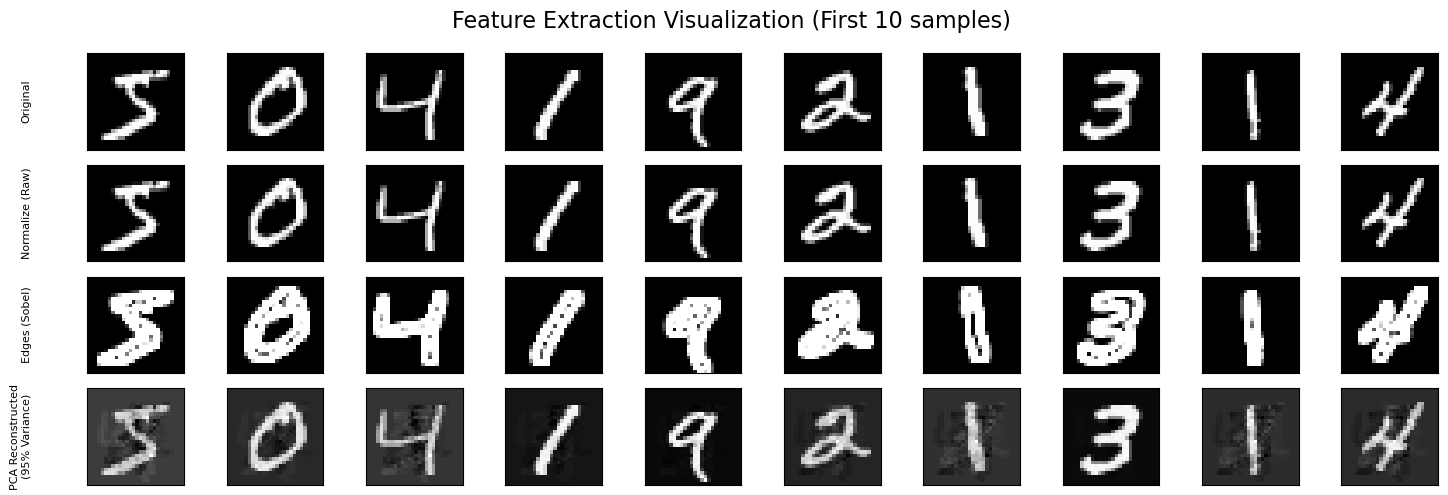

In [6]:
# VISUALIZE IMAGES AFTER FEATURE EXTRACTION
def visualize_feature_extraction(X_raw, n_samples=10):
    """
    X_raw: Dữ liệu ảnh gốc (N, 28, 28)
    n_samples: Số lượng ảnh muốn hiển thị
    """
    fe = FeatureEngineer(variance_ratio=0.95)

    # Lấy n mẫu đầu tiên
    indices = range(n_samples)
    samples = X_raw[indices]

    # 1. Xử lý Raw 
    X_raw_flat = fe.process(samples, method='raw', is_training=True).T

    # 2. Xử lý Edges
    X_edges = fe.process(samples, method='edges', is_training=True).T

    # 3. Xử lý PCA
    X_pca_vectors = fe.process(samples, method='pca', is_training=True).T
    
    X_pca_recon = cv2.PCABackProject(X_pca_vectors, fe.mean, fe.eigenvectors)

    fig, axes = plt.subplots(4, n_samples, figsize=(n_samples * 1.5, 5))
    plt.subplots_adjust(hspace=0.5)

    rows = ["Original", "Normalize (Raw)", "Edges (Sobel)", "PCA Reconstructed\n(95% Variance)"]
    data_list = [samples, X_raw_flat, X_edges, X_pca_recon]

    for r in range(4):
        axes[r, 0].set_ylabel(rows[r], fontsize=8, rotation=90, labelpad=40)
        
        for i in range(n_samples):
            img = data_list[r][i].reshape(28, 28)
            
            axes[r, i].imshow(img, cmap='gray')
            axes[r, i].set_xticks([])
            axes[r, i].set_yticks([])

    plt.suptitle(f"Feature Extraction Visualization (First {n_samples} samples)", fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()

visualize_feature_extraction(X_train_full_img, n_samples=10)


RUNNING EXPERIMENT: Design 1: Raw Pixels
[Epoch 1/1000] Loss: 0.5024 | Val Loss: 0.4872 | Val Acc: 0.8788
[Epoch 10/1000] Loss: 0.3190 | Val Loss: 0.3134 | Val Acc: 0.9136
[Epoch 20/1000] Loss: 0.2935 | Val Loss: 0.2928 | Val Acc: 0.9186
[Epoch 30/1000] Loss: 0.2823 | Val Loss: 0.2860 | Val Acc: 0.9202
[Epoch 40/1000] Loss: 0.2758 | Val Loss: 0.2808 | Val Acc: 0.9223
[Epoch 50/1000] Loss: 0.2719 | Val Loss: 0.2807 | Val Acc: 0.9207
[Epoch 60/1000] Loss: 0.2655 | Val Loss: 0.2756 | Val Acc: 0.9231
[Epoch 70/1000] Loss: 0.2624 | Val Loss: 0.2739 | Val Acc: 0.9237
[Epoch 80/1000] Loss: 0.2598 | Val Loss: 0.2721 | Val Acc: 0.9238
[Epoch 90/1000] Loss: 0.2578 | Val Loss: 0.2717 | Val Acc: 0.9245
[Epoch 100/1000] Loss: 0.2556 | Val Loss: 0.2708 | Val Acc: 0.9249
[Epoch 110/1000] Loss: 0.2540 | Val Loss: 0.2708 | Val Acc: 0.9250
Val Loss không giảm 1 lần.
[Epoch 120/1000] Loss: 0.2527 | Val Loss: 0.2700 | Val Acc: 0.9253
[Epoch 130/1000] Loss: 0.2510 | Val Loss: 0.2696 | Val Acc: 0.9253
[Epo

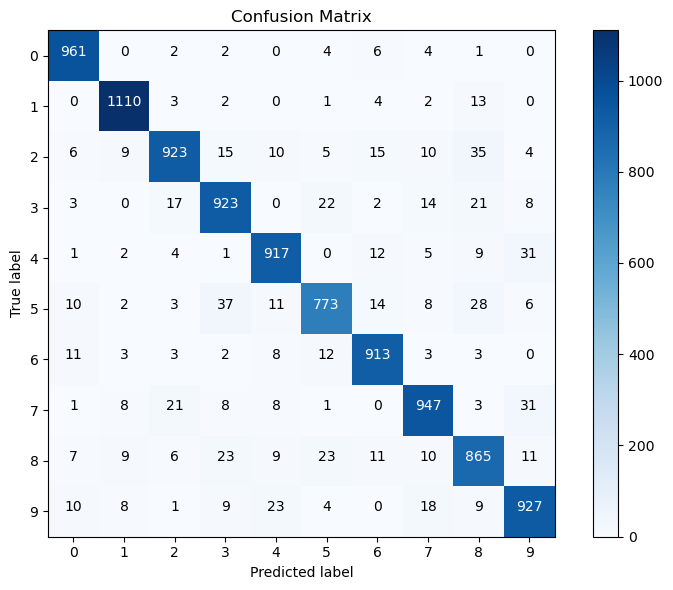


RUNNING EXPERIMENT: Design 2: Edge Detection
[Epoch 1/1000] Loss: 0.5178 | Val Loss: 0.5238 | Val Acc: 0.8494
[Epoch 10/1000] Loss: 0.3784 | Val Loss: 0.4056 | Val Acc: 0.8812
[Epoch 20/1000] Loss: 0.3555 | Val Loss: 0.3929 | Val Acc: 0.8819
[Epoch 30/1000] Loss: 0.3452 | Val Loss: 0.3840 | Val Acc: 0.8885
[Epoch 40/1000] Loss: 0.3344 | Val Loss: 0.3797 | Val Acc: 0.8884
[Epoch 50/1000] Loss: 0.3293 | Val Loss: 0.3791 | Val Acc: 0.8870
[Epoch 60/1000] Loss: 0.3240 | Val Loss: 0.3756 | Val Acc: 0.8899
[Epoch 70/1000] Loss: 0.3204 | Val Loss: 0.3756 | Val Acc: 0.8881
[Epoch 80/1000] Loss: 0.3185 | Val Loss: 0.3764 | Val Acc: 0.8892
Val Loss không giảm 1 lần.
[Epoch 90/1000] Loss: 0.3165 | Val Loss: 0.3762 | Val Acc: 0.8878
Val Loss không giảm 2 lần.
[Epoch 100/1000] Loss: 0.3115 | Val Loss: 0.3747 | Val Acc: 0.8891
[Epoch 110/1000] Loss: 0.3096 | Val Loss: 0.3745 | Val Acc: 0.8896
[Epoch 120/1000] Loss: 0.3117 | Val Loss: 0.3774 | Val Acc: 0.8859
Val Loss không giảm 1 lần.
[Epoch 130/10

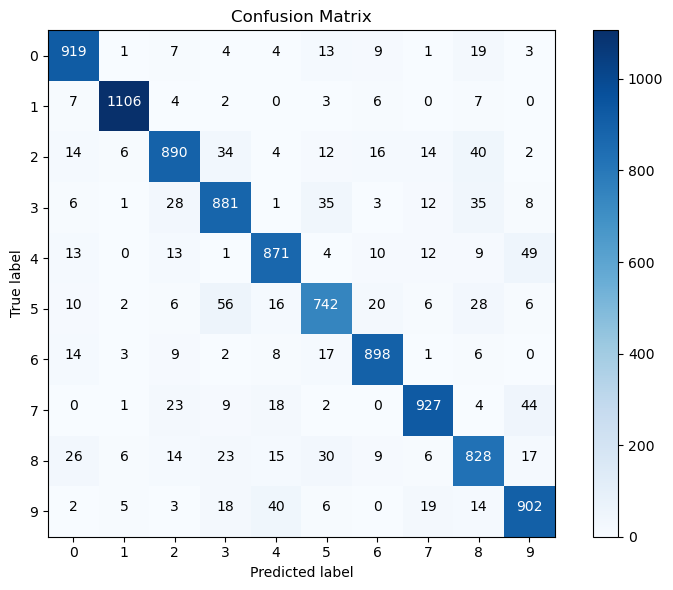


RUNNING EXPERIMENT: Design 3: PCA
[Epoch 1/1000] Loss: 0.5021 | Val Loss: 0.4895 | Val Acc: 0.8742
[Epoch 10/1000] Loss: 0.3253 | Val Loss: 0.3192 | Val Acc: 0.9100
[Epoch 20/1000] Loss: 0.3022 | Val Loss: 0.2994 | Val Acc: 0.9157
[Epoch 30/1000] Loss: 0.2921 | Val Loss: 0.2913 | Val Acc: 0.9177
[Epoch 40/1000] Loss: 0.2862 | Val Loss: 0.2864 | Val Acc: 0.9196
[Epoch 50/1000] Loss: 0.2822 | Val Loss: 0.2839 | Val Acc: 0.9201
[Epoch 60/1000] Loss: 0.2794 | Val Loss: 0.2820 | Val Acc: 0.9214
[Epoch 70/1000] Loss: 0.2772 | Val Loss: 0.2803 | Val Acc: 0.9215
[Epoch 80/1000] Loss: 0.2755 | Val Loss: 0.2792 | Val Acc: 0.9221
[Epoch 90/1000] Loss: 0.2741 | Val Loss: 0.2784 | Val Acc: 0.9217
[Epoch 100/1000] Loss: 0.2730 | Val Loss: 0.2778 | Val Acc: 0.9222
[Epoch 110/1000] Loss: 0.2720 | Val Loss: 0.2773 | Val Acc: 0.9212
[Epoch 120/1000] Loss: 0.2712 | Val Loss: 0.2767 | Val Acc: 0.9216
[Epoch 130/1000] Loss: 0.2705 | Val Loss: 0.2764 | Val Acc: 0.9223
[Epoch 140/1000] Loss: 0.2698 | Val Lo

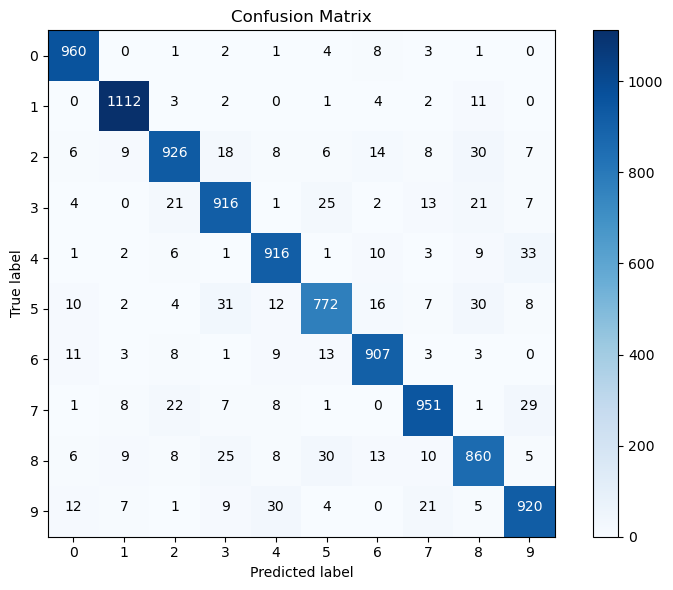


================ SUMMARY ================


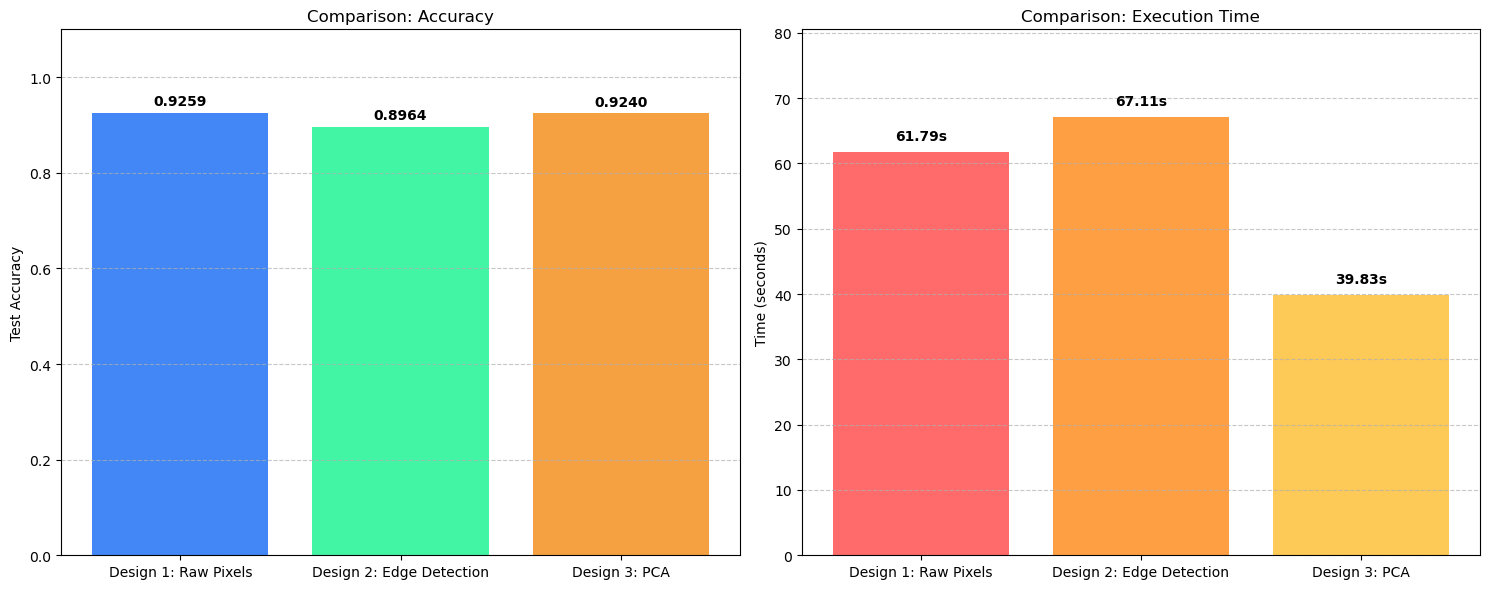

In [7]:
# MAIN EXPERIMENT

# 1. Định nghĩa các cấu hình thí nghiệm
experiments = [
    {"name": "Design 1: Raw Pixels", "method": "raw"},
    {"name": "Design 2: Edge Detection", "method": "edges"},
    {"name": "Design 3: PCA", "method": "pca"}
]

engineer = FeatureEngineer() # Có thể thêm tham số variance_ratio nếu muốn
results_acc = {}
results_time = {}

# 2. Chạy vòng lặp so sánh
for exp in experiments:
    print(f"\n==========================================")
    print(f"RUNNING EXPERIMENT: {exp['name']}")
    print(f"==========================================")
    
    start_time = time.time()
    
    X_train = engineer.process(X_train_img, method=exp['method'], is_training=True)
    
    X_val = engineer.process(X_val_img, method=exp['method'], is_training=False)
    X_test = engineer.process(X_test_img, method=exp['method'], is_training=False)

    model = SoftmaxRegression()
    model.fit(X_train, y_train, X_val, y_val)
    
    y_pred = model.predict(X_test)
    end_time = time.time()
    elapsed_time = end_time - start_time
    results_time[exp['name']] = elapsed_time

    acc = np.mean(y_test == y_pred)
    results_acc[exp['name']] = acc
    print(f"     Final Test Accuracy: {acc:.4f}")
    
    model.save_model(f"models/softmax_model_{exp['method']}.pkl", feature_engineer=engineer if exp['method']=='pca' else None)
    
    # Vẽ Confusion Matrix
    print(f"Visualizing Confusion Matrix for {exp['name']}...")
    # Đảm bảo hàm evaluate_metrics trả về cm
    cm = evaluate_metrics(y_test, y_pred) 
    plot_confusion_matrix(cm)
    
# 3. Kết quả
print("\n================ SUMMARY ================")
names = list(results_acc.keys())
accs = list(results_acc.values())
times = list(results_time.values())

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Biểu đồ 1: Accuracy 
bars1 = ax[0].bar(names, accs, color=['#4287f5', '#42f5a4', '#f5a142'])
ax[0].set_ylim(0.0, 1.1)
ax[0].set_ylabel('Test Accuracy')
ax[0].set_title('Comparison: Accuracy')
ax[0].grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars1:
    yval = bar.get_height()
    ax[0].text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.4f}", 
               ha='center', va='bottom', fontweight='bold')

# Biểu đồ 2: Execution Time 
bars2 = ax[1].bar(names, times, color=['#ff6b6b', '#ff9f43', '#feca57'])
max_time = max(times) if times else 1
ax[1].set_ylim(0, max_time * 1.2) 
ax[1].set_ylabel('Time (seconds)')
ax[1].set_title('Comparison: Execution Time')
ax[1].grid(axis='y', linestyle='--', alpha=0.7)

# Hiển thị số liệu Time
for bar in bars2:
    yval = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width()/2, yval + (max_time * 0.02), f"{yval:.2f}s", 
               ha='center', va='bottom', fontweight='bold', color='black')

plt.tight_layout()
plt.show()